# Boston Housing Prices Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [2]:
# Matplotlib has some built in style sheets
mpl.style.use('fivethirtyeight')

## Data Loading

Notice that I am loading in the data in the same way that we did for our visualization module. Time to refactor? It migth be good to abstract away some of this as functions, that way we aren't copying and pasting code between all of our notebooks.

In [3]:
boston = datasets.load_boston()

# Sklearn uses a dictionary like object to hold its datasets
X = boston['data']
y = boston['target']

feature_names = list(boston.feature_names)

In [4]:
X_df = pd.DataFrame(X)
X_df.columns = boston.feature_names
X_df["PRICE"] = y 

X_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
def create_classes(data):
    """Create our classes using thresholds
    
    This is used as an `apply` function for
    every row in `data`.
    
    Args:
        data: pandas dataframe
    """
    if data["PRICE"] < 16.:
        return 0
    elif data["PRICE"] >= 16. and data["PRICE"] < 22.:
        return 1
    else:
        return 2

In [6]:
y = X_df.apply(create_classes, axis=1)

# Get stats for plotting
classes, counts = np.unique(y, return_counts=True)

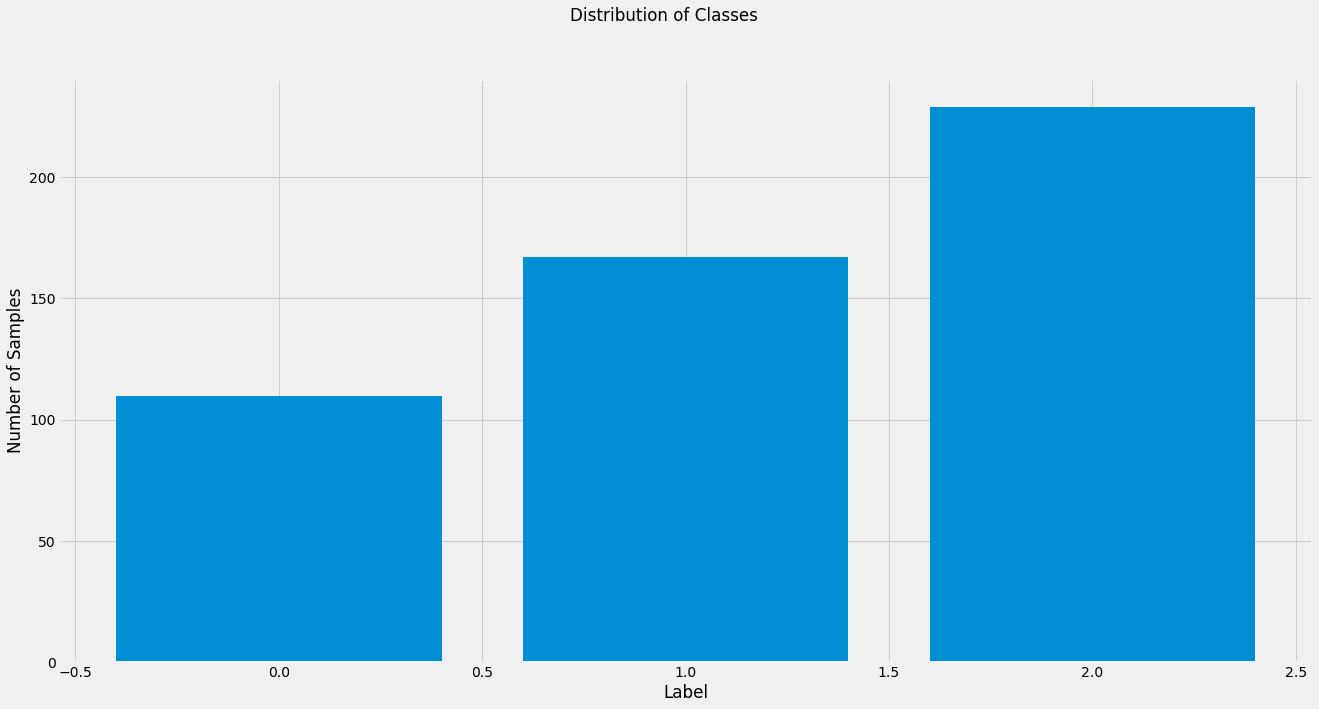

In [7]:
plt.figure(figsize=(20, 10))

plt.bar(classes, counts)

plt.xlabel("Label")
plt.ylabel(r"Number of Samples")
plt.suptitle("Distribution of Classes")
plt.show()

## Support Vector Machine

In [8]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Args:
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional

    Returns:
        xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [9]:
# Careful, `loc` uses inclusive bounds!
X = X_df.loc[:99, ['LSTAT', 'PRICE']].values
y = y[:100]


C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))

models = (clf.fit(X, y) for clf in models)

/Users/ygx/.local/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


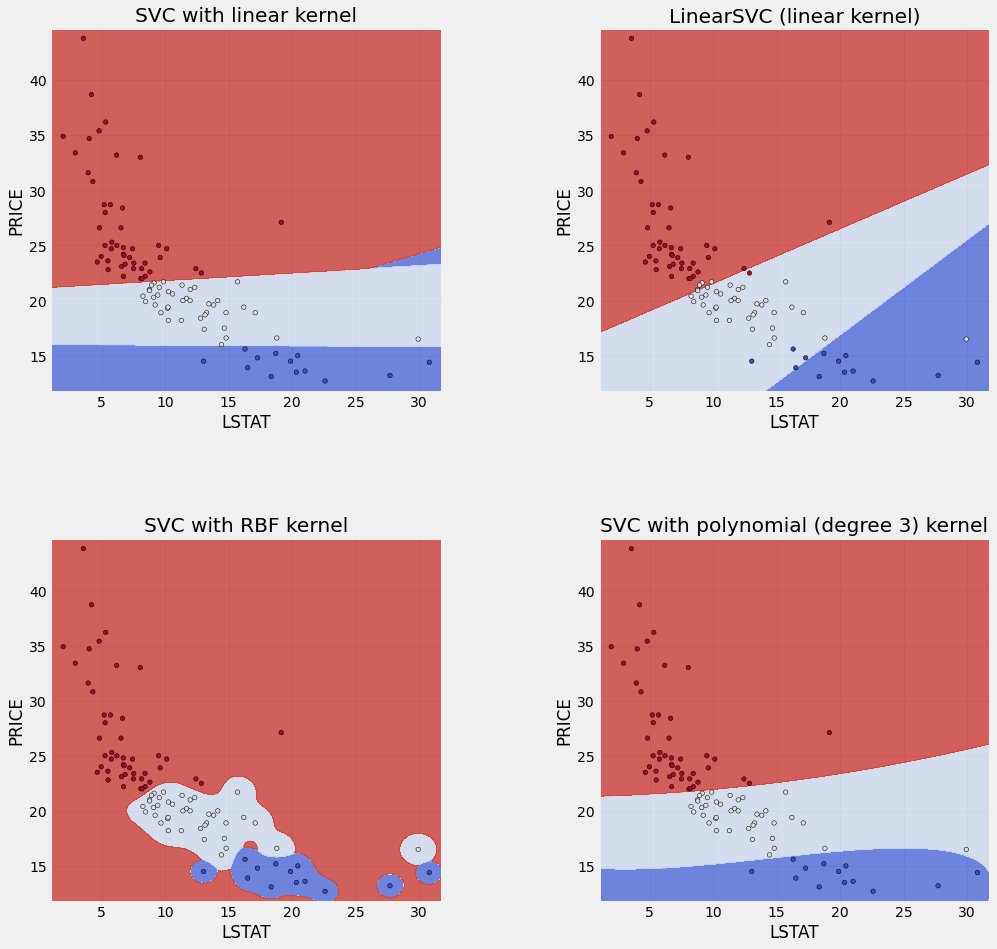

In [10]:
# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('LSTAT')
    ax.set_ylabel('PRICE')
    ax.set_title(title)

plt.show()